# Produce figures for a poster

In [ ]:
import xarray as xr
import cmocean
import matplotlib.pyplot as plt
import numpy as np
import sys
import tqdm
sys.path.append('/home/users/birgal/')
from nemo_python_git.plots import circumpolar_plot, finished_plot

In [ ]:
mesh = xr.open_dataset('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/bathymetry/mesh_mask-20240305.nc').isel(time_counter=0)
dom  = xr.open_dataset('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/bathymetry/domain_cfg-20240305.nc')

In [ ]:
run_folderJ = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/output/JRA55_test2/'
run_folderE = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/output/ERA5_test2/'

# Convection

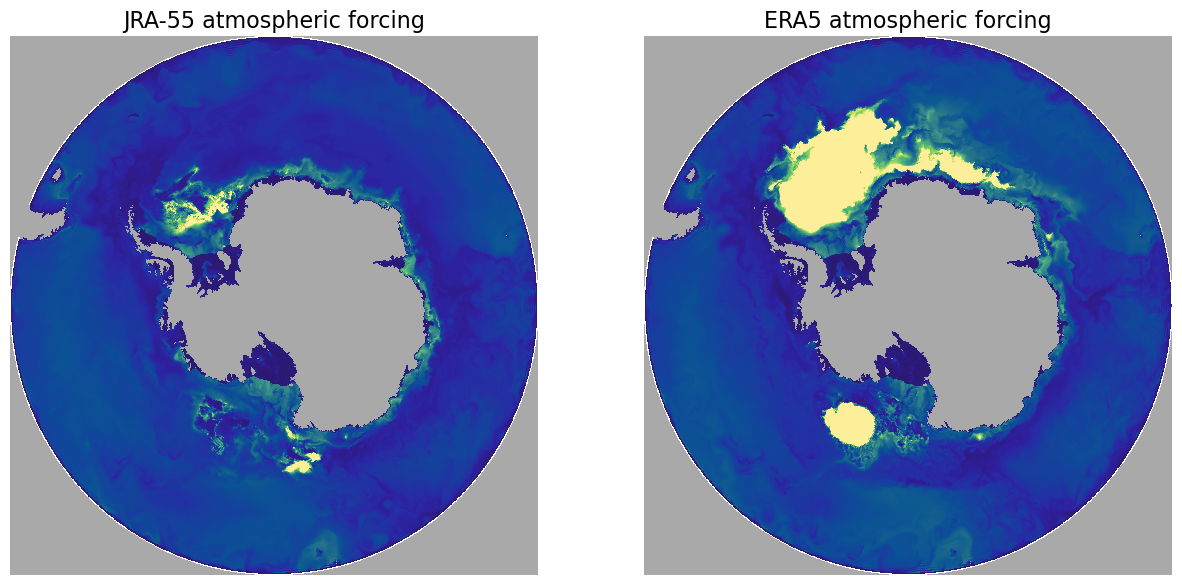

In [4]:
var = 'mldr10_1'
vlim= (0,1000)
t   = 7
dsJ  = xr.open_dataset(f'{run_folderJ}eANT025.L121_1m_19980101_19981231_grid_T.nc')
dsE  = xr.open_dataset(f'{run_folderE}eANT025.L121_1m_19980101_19981231_grid_T.nc')

fig, ax = plt.subplots(1,2, figsize=(15,7))
circumpolar_plot(dsJ[var].isel(time_counter=t), mesh, ax=ax[0], make_cbar=False, 
                 return_fig=False, ctype=cmocean.cm.haline, lat_max=-50, vmin=vlim[0], vmax=vlim[1],
                 title=f'JRA-55 atmospheric forcing')
circumpolar_plot(dsE[var].isel(time_counter=t), mesh, ax=ax[1], make_cbar=False, 
                 return_fig=False, ctype=cmocean.cm.haline, lat_max=-50, vmin=vlim[0], vmax=vlim[1],
                 title=f'ERA5 atmospheric forcing')
# fig.tight_layout()
# finished_plot(fig, print_out=False, fig_name=f'/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/figures/convection.jpg')

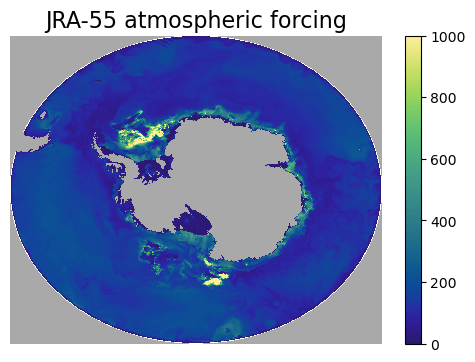

In [5]:
fig, ax = plt.subplots(1,1, figsize=(6,4))

# plt.style.use("dark_background")
circumpolar_plot(dsJ[var].isel(time_counter=t), mesh, ax=ax, make_cbar=True, 
                 return_fig=False, ctype=cmocean.cm.haline, lat_max=-50, vmin=vlim[0], vmax=vlim[1],
                 title=f'JRA-55 atmospheric forcing')

fig.patch.set_alpha(0.0)
# finished_plot(fig, print_out=False, fig_name=f'/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/figures/colorbar.png')

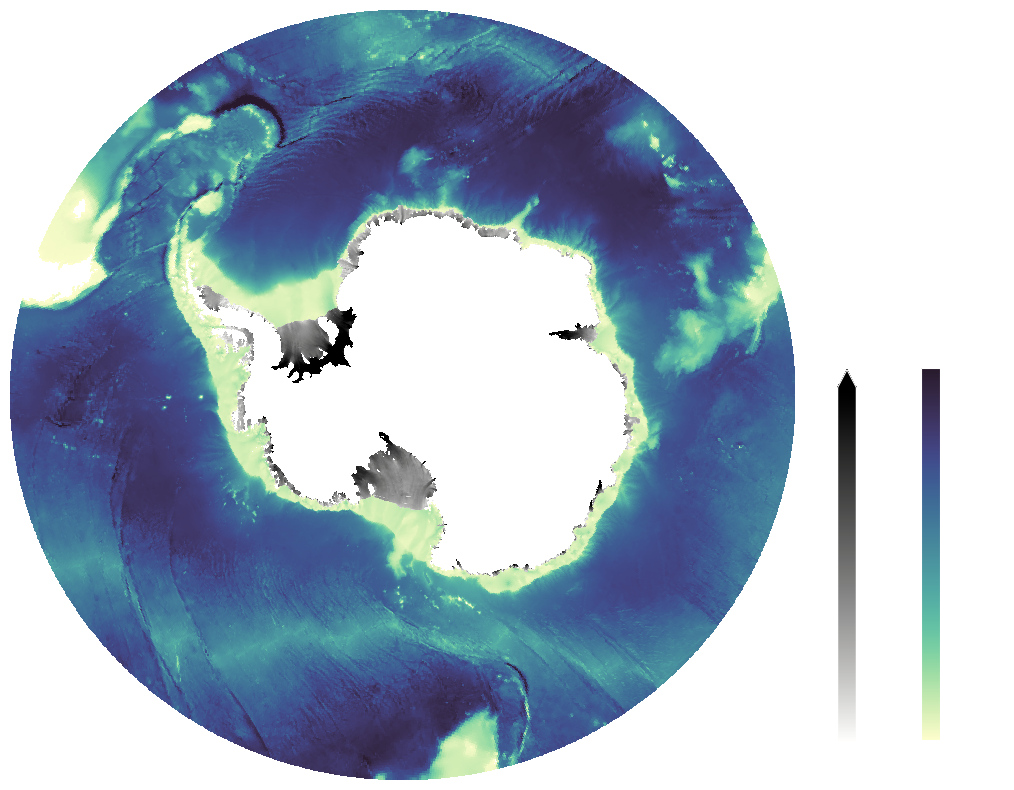

In [12]:
fig, ax = plt.subplots(1,1, figsize=(12,10))

plt.style.use("dark_background")
circumpolar_plot(dom.bathy_metry.isel(time_counter=0), mesh, ax=ax,
                 make_cbar=True, lat_max=-50, shade_land=False, ctype=cmocean.cm.deep, vmin=0, vmax=6000, 
                 cbar_kwags={'label':'Sea floor depth (m)', 'fraction':0.02, 'pad':0.07, 'anchor':(0.0, 0.1)})

circumpolar_plot(dom.isf_draft.isel(time_counter=0), mesh, ax=ax,
                 make_cbar=True, lat_max=-50, shade_land=False, ctype=cmocean.cm.gray_r, vmin=0, vmax=800,
                 cbar_kwags={'label':'Ice shelf draft (m)', 'extend':'max', 'fraction':0.022, 'anchor':(0.0, 0.1)})
ax.set_title('');
fig.patch.set_alpha(0.0)

# finished_plot(fig, fig_name='/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/figures/AntArc_bathy_isfdraft_transparant.jpg', dpi=80)

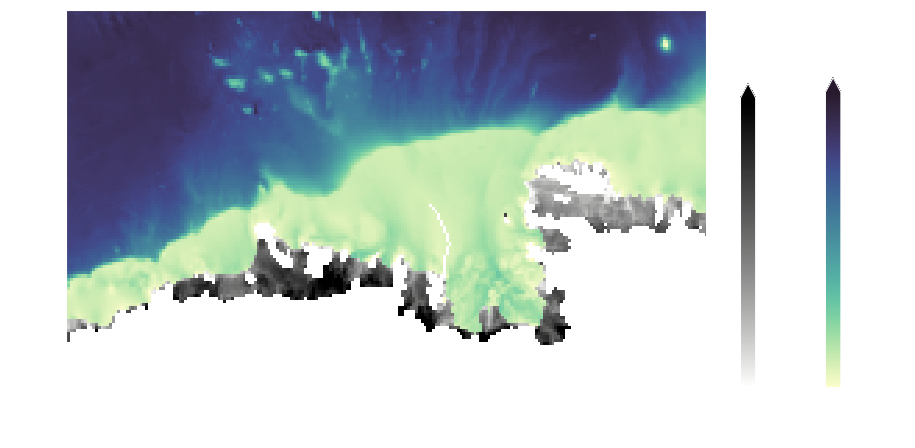

In [15]:
fig, ax = plt.subplots(1,1, figsize=(10,5))

kwags1={'cmap':cmocean.cm.deep, 'vmin':0, 'vmax':5000}
kwags2={'cmap':cmocean.cm.gray_r, 'vmin':0, 'vmax':600}

plt.style.use("dark_background")
mbathy_plot   = xr.where(mesh.tmask.isel(nav_lev=0)==0, np.nan, dom.bathy_metry.isel(time_counter=0))
isfdraft_plot = xr.where(dom.isel(time_counter=0).isf_draft <=0, np.nan, dom.isf_draft.isel(time_counter=0))
cm5 = ax.pcolormesh(dom.x, dom.y, mbathy_plot, **kwags1)
cm6 = ax.pcolormesh(dom.x, dom.y, isfdraft_plot, **kwags2)
ax.set_xlim(570,800)
ax.set_ylim(190,310)

CB5 = fig.colorbar(cm5, ax=ax, anchor=(0,0.1), fraction=0.02, pad=0.09, extend='max', label='Bathymetry depth (m)')
CB6 = fig.colorbar(cm6, ax=ax, anchor=(0,0.1), fraction=0.022, extend='max', label='Ice shelf draft (m)')
ax.set_xlabel('x-index')
ax.set_ylabel('y-index')

fig.patch.set_alpha(0.0)
ax.set_facecolor('w')

# Hovmoeller plots

In [ ]:
# location: somewhere where deep convection occurs --> Weddell Sea and also check Ross Gyre region (1989, 1991, 2004, 2006)
# ts.amundsen_sea_bwtemp
weddell_convect = {'x':slice(930,1150), 'y':slice(295,360)}
ross_convect    = {'x':slice(450,580),  'y':slice(220,300)}

In [ ]:
def calc_hovmoeller(var, region, run_folder=run_folderJ, nemo_mesh=mesh):
    i=0
    nemo_mesh_subset = nemo_mesh.rename({'x':'x_grid_T','y':'y_grid_T','nav_lev':'deptht'}).isel(x_grid_T=region['x'], y_grid_T=region['y'])
    for year in tqdm.tqdm(range(1979,2005)):
        with xr.open_dataset(f'{run_folder}eANT025.L121_1m_{year}0101_{year}1231_grid_T.nc').isel(x_grid_T=region['x'], y_grid_T=region['y']) as ds:
            var_ocean  = xr.where(nemo_mesh_subset.tmask==0, np.nan, ds[var]) 
            area_ocean = xr.where(nemo_mesh_subset.tmask==0, np.nan, ds['area_grid_T']) 
            var_ds     = (var_ocean*area_ocean).sum(dim=['x_grid_T','y_grid_T'])/(area_ocean.sum(dim=['x_grid_T','y_grid_T']))
            if i==0:
                convect_ts = var_ds
            else:
                convect_ts = xr.concat([convect_ts, var_ds], dim='time_counter')
        
        i+=1
    return convect_ts

In [ ]:
salt_wedE   = calc_hovmoeller('so', weddell_convect, run_folder=f'{run_folderE}/', nemo_mesh=mesh)
salt_wedJ   = calc_hovmoeller('so', weddell_convect, run_folder=f'{run_folderJ}/', nemo_mesh=mesh)
# thetao_wedE = calc_hovmoeller('thetao', weddell_convect, run_folder=f'{run_folderE}/', nemo_mesh=mesh)
# thetao_wedJ = calc_hovmoeller('thetao', weddell_convect, run_folder=f'{run_folderJ}/', nemo_mesh=mesh)

  0%|          | 0/26 [00:00<?, ?it/s]

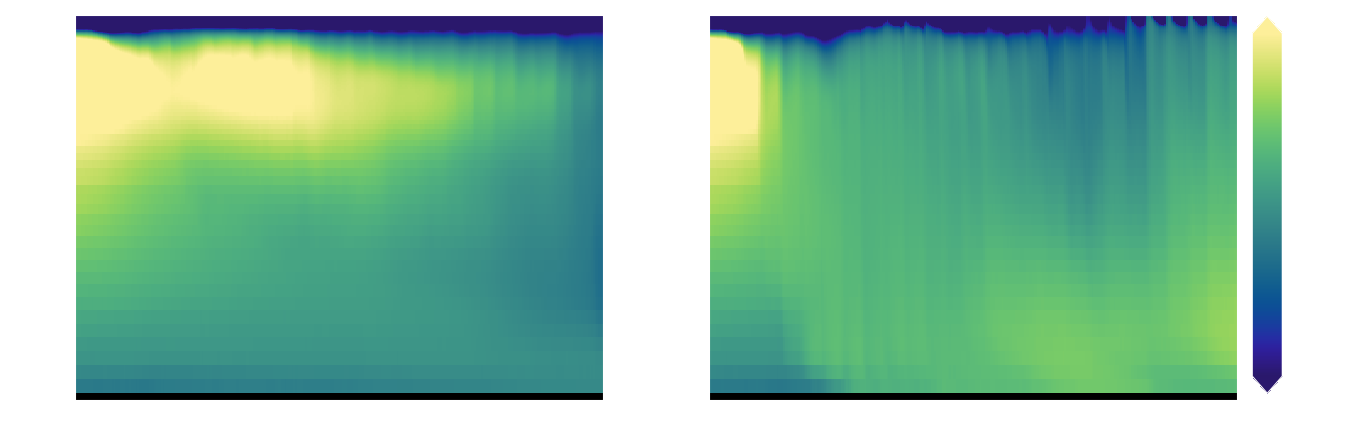

In [27]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

slim=(34.82,34.86) 
tlim=(-1.5, 0.5)
ylim=(5500,0)

# plt.style.use("dark_background")

cm1 = ax[0].pcolormesh(salt_wedJ.time_centered, salt_wedJ.deptht, salt_wedJ, rasterized=True, cmap=cmocean.cm.haline, vmin=slim[0], vmax=slim[1])
cm2 = ax[1].pcolormesh(salt_wedE.time_centered, salt_wedE.deptht, salt_wedE, rasterized=True, cmap=cmocean.cm.haline, vmin=slim[0], vmax=slim[1])
cbax = fig.add_axes([.91,.124,.02,.754])
fig.colorbar(cm2, label='Salinity', extend='both', cax=cbax)
for axis in ax.ravel():
    axis.invert_yaxis()
    axis.set_ylabel('Depth (m)')
    axis.set_ylim(ylim[0],ylim[1])

fig.patch.set_alpha(0.0)

# ax[0].set_title('JRA-55 atmospheric forcing')
# ax[1].set_title('ERA5 atmospheric forcing')
# finished_plot(fig, fig_name='/gws/nopw/j04/terrafirma/birgal/figures/.jpg')